##### Exploratory Data Analysis of:
## Microsoft, Apple, Amazon, Google, Netflix, and Facebook Workplace Reviews
___
**Context:** We have over 67k workplace reviews for Google, Amazon, Facebook, Apple, Netflix, and Microsoft. The dataset is hosted on [Kaggle](https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews) and is scraped from www.glassdoor.com.

**Table of contents:**

Wrangling and Exploration

1. [Libraries, Settings and Loading the Dataset](#Libraries)
1. [Variables Assessment, Data Cleaning, and Univariant Exploration](#Univariant)
1. [What insights and questions are we exploring?](#Context)
1. [Bivariate and Multivariate Explorations](#Multivariate)
1. [Feature Engineering](#Feature)
___

## Libraries, Settings and Loading the Dataset <a name="Libraries"></a>

In [1]:
# Fundamental libraries for scientific computing
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Python Standard Libraries
import os  # For os file operations.
import re  # Used for data cleaning purposes.
import webbrowser  # Used to see sample reviews in glassdoor.com

# Ensures plots to be embedded inline.
%matplotlib inline

# Plot size frequently used.
two_in_row = (12, 4)  
# Style and Base color used for seaborn plots.
bcolor = sns.color_palette()[0]
sns.set(style='ticks', palette='pastel')

# Suppress warnings from final output.
import warnings
warnings.simplefilter("ignore")

In [2]:
def start():
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 25,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 40,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 2,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)

In [3]:
start(); del start

#### Load up the dataset and first look at the data

In [4]:
dataset_path = 'input/'
df = pd.read_csv(os.path.join(dataset_path, 'employee_reviews.csv'), index_col=0)

#### Let's look at shape of our raw data and  three  random  reviews:

In [5]:
print('Number of rows (reviews) and columns:', df.shape)
df_samples = df.sample(3)
df_samples

Number of rows (reviews) and columns: (67529, 16)


,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
53719,microsoft,"Seattle, WA","Mar 14, 2016",Current Employee - Su...,Overall great place t...,"The people, benefits,...",Forced attrition - a ...,Eliminate forced attr...,4.0,4.0,4.0,4.0,4.0,3.0,1,https://www.glassdoor...
16220,amazon,"Louisville, KY","Mar 30, 2017",Current Employee - An...,Esl pack couch,Because of there deve...,I don't have any idea...,In my shift they are ...,5.0,3.0,5.0,none,none,none,0,https://www.glassdoor...
9626,amazon,none,"Jul 30, 2018",Current Employee - An...,Customer service amazon,"Work from home, stock...","Pay, rude customers, ...",none,3.0,none,none,none,none,none,1,https://www.glassdoor...


In [6]:
random_review = np.random.randint(0, df.shape[0]-1)
df.iloc[random_review] # A detailed look at a random review

company                                         amazon
location                      Dublin, Co. Dublin (I...
dates                                     Aug 10, 2018
job-title                     Current Employee - Cl...
summary                                       Good job
pros                          good company to be wo...
cons                          base salary could be ...
advice-to-mgmt                                    none
overall-ratings                                      5
work-balance-stars                                 5.0
culture-values-stars                               5.0
carrer-opportunities-stars                         5.0
comp-benefit-stars                                 4.0
senior-mangemnet-stars                             4.0
helpful-count                                        0
link                          https://www.glassdoor...
Name: 26607, dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67529 entries, 1 to 67529
Data columns (total 16 columns):
company                       67529 non-null object
location                      67529 non-null object
dates                         67529 non-null object
job-title                     67529 non-null object
summary                       67409 non-null object
pros                          67529 non-null object
cons                          67529 non-null object
advice-to-mgmt                67232 non-null object
overall-ratings               67529 non-null float64
work-balance-stars            67529 non-null object
culture-values-stars          67529 non-null object
carrer-opportunities-stars    67529 non-null object
comp-benefit-stars            67529 non-null object
senior-mangemnet-stars        67529 non-null object
helpful-count                 67529 non-null int64
link                          67529 non-null object
dtypes: float64(1), int64(1), object(14)
memory usage: 8.8+

We don't see lots of missing data but that's most likely because missing data represented by string 'none'

In [8]:
df.nunique()

company                           6
location                       2044
dates                          3824
job-title                      8308
summary                       42649
pros                          66085
cons                          66049
advice-to-mgmt                35190
overall-ratings                   5
work-balance-stars               10
culture-values-stars              6
carrer-opportunities-stars       10
comp-benefit-stars               10
senior-mangemnet-stars           10
helpful-count                    99
link                           6754
dtype: int64

We have four specific categories of ratings and one overall rating. They should be based on a 1-star to 5-stars ratings, but there are up to 10 different vlues for those ratings that needs to be looked at and cleaned.

#### Reviews on the glassdoor.com
We can follow our sample scrapped reviews to www.glassdoor.com to see the actual reviews.

In [9]:
links = df_samples['link']
print(links)
answer = input('Enter,  y  if you would like to open and see these sample reviews\` urls? ')
if answer.lower()=='y':
    [webbrowser.open(link) for link in links]

53719    https://www.glassdoor...
16220    https://www.glassdoor...
9626     https://www.glassdoor...
Name: link, dtype: object
Enter,  y  if you would like to open and see these sample reviews\` urls? 


Looking at the actual source of the data, we can see  two very likely useful peices of information in reviews are not scrapped. That is the length and type of employments. Here is 3 examples:
 - I worked at Amazon full-time (More than 3 years)
 - I have been working at Microsoft full-time (More than 10 years)
 - I have been working at Google full-time (Less than a year)

end of quick look
___

## Variables Assessment, Data Cleaning, and Univariant Exploration <a name="Univariant"></a>

Make column names Python/Pandas friendly by changinh dashes to underscors

In [10]:
df.columns

Index(['company', 'location', 'dates', 'job-title', 'summary', 'pros', 'cons',
       'advice-to-mgmt', 'overall-ratings', 'work-balance-stars',
       'culture-values-stars', 'carrer-opportunities-stars',
       'comp-benefit-stars', 'senior-mangemnet-stars', 'helpful-count',
       'link'],
      dtype='object')

In [11]:
df.columns = df.columns.str.replace('-', '_') 

**1st Column** `company` is the company name

Companies in this data set are just names and have no order. To add more meaning for this column we will convert it to an ordinal categorical type sorted by date founded, from Microsoft to Facebook. 

In [12]:
companies_by_founded_date = ['microsoft', 'apple', 'amazon', 'netflix', 'google', 'facebook']
company_cat = CategoricalDtype(ordered=True, categories=companies_by_founded_date)
df['company'] = df['company'].astype(company_cat)
# TEST
df['company'].values

[google, google, google, google, google, ..., microsoft, microsoft, microsoft, microsoft, microsoft]
Length: 67529
Categories (6, object): [microsoft < apple < amazon < netflix < google < facebook]

In [13]:
def plot_cat_counts(data=None, x=None):
    """Plot a categorical value with side by side horizantal bar and pie charts"""
    
    plt.figure(figsize=two_in_row)

    plt.subplot(1, 2, 1)
    sns.countplot(data=data, y=x, color=bcolor)
    plt.ylabel('')
    plt.xlabel('Review Counts')
    sns.despine() # remove the top and right borders


    plt.subplot(1, 2, 2)
    sorted_counts = data[x].value_counts()
    labels = sorted_counts.index

    plt.pie(sorted_counts, labels=None, 
            startangle=90, counterclock=False, wedgeprops = {'width' : 0.35})
    plt.axis('square')

    plt.legend(labels,
              title="Companies Proportions",
              loc="top left",
              bbox_to_anchor=(1, 0, .25, 1));

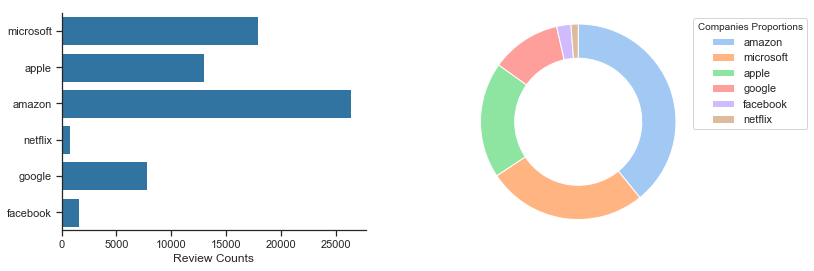

In [14]:
plot_cat_counts(df, 'company')

#### Notes:
The disproportionate distributions of reviews between these 6 companies considering their scope of operations and year founded are consistent with our expectations. Microsoft and Apple founded in the mid-seventies, Amazon founded in 1994, Netflix with a DVD rental business model in 1997, Google in 1998 and most recently Facebook in 2004. Glassdoor, the review site itself, founded in 2007. 
___

**2nd Column** `location`
This dataset is global. As such, it may include the country's name in parenthesis, i.e., "Toronto, ON(Canada)"]. However, if the location is in the USA, then it only includes the city and state, i.e., "Los Angeles, CA" ]

- `none` is used for missing values in this data set. This shows in this bar plot as more than 35% of locations are missing.

In [15]:
# Replace string "none" with NaN in entire dataset.
df = df.replace('none', np.nan)
df = df.replace('None', np.nan)
df = df.replace('None.', np.nan)

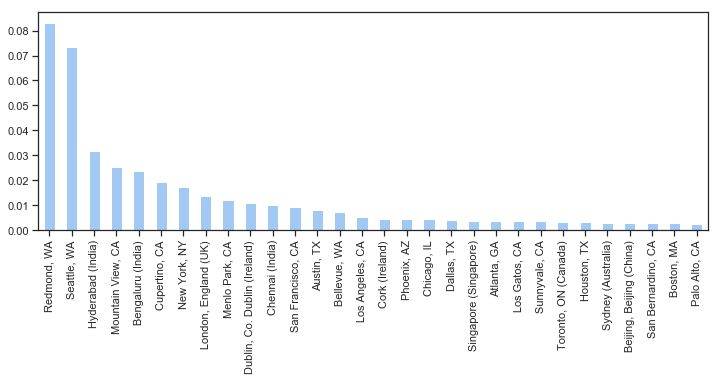

In [16]:
# Plot top 30 frequent locations
plt.figure(figsize=two_in_row)
(df['location'].value_counts().head(30) / len(df)).plot.bar();

**Findings** 
- **This column is not Tidy.** There are 3 values of  `city, state, country` in this one column that each should be in its own column.
- Location values are in two different formats.
- - For the US, country name is missing and we have City, State
- - For other countries the format is City, State/Region if applies, and the Country name between parentheses.

##### Functions to extract `city`, `state`, and `country` values from location column to 3 columns

In [17]:
btween_parentheses = r'\(([^)]+)\)'  # Regular expression to get a string between parentheses

def get_country(location):
    """Extracts and returns country name from location string.
    Returns NaN if 'none'."""
    
    if pd.isnull(location):
        return np.nan
    
    not_usa = re.findall(btween_parentheses, location)
    if not_usa:
        return not_usa[0]
    else:
        return 'USA'
    

def get_state(location):
    """Extracts and returns state name (if aby) from location string.
    Returns Nan if 'none or not applicable."""
    
    if pd.isnull(location):
        return np.nan
    
    not_usa = re.findall(btween_parentheses, location)
    if not_usa:
        if ',' in location:
            return location.split(',')[1].split()[0]
        else:
            return np.nan
    else:
        return location.strip()[-2:]

    
def get_city(location):
    """Extracts and returns city name from location string.
    Returns Nan if 'none'."""
    
    if pd.isnull(location):
        return np.nan
    
    not_usa = re.findall(btween_parentheses, location)
    if not_usa:
        if ',' in location:
            return location.split(',')[0]
        else:
            return location.split()[0]
    else:
        return location.split(',')[0]    

In [18]:
# Creating three new columns for location data
df['city'] = df['location'].apply(get_city)  # New column for the city.
df['state'] = df['location'].apply(get_state)  # New column for the State/Region.
df['country'] = df['location'].apply(get_country)  # New Column for the Country.

# Drop the untidy and no longer needed location column.
del df['location']

In [19]:
# TEST location columns
df[['city', 'state', 'country']].sample(5)

,city,state,country
9691,Middletown,DE,USA
50879,NaN,NaN,NaN
58353,Redmond,WA,USA
44645,New York,NY,USA
43305,San Francisco,CA,USA


In [20]:
def plot_top_cats(col, top_percentage):
    """Plot members of a categorical variable that make up the top_percentage."""
    
    mask = df[col].value_counts(normalize=True).cumsum() < top_percentage
    top_items = mask[mask].index

    def group_top_itesm(x):
        if x in top_items:
            return x
        elif pd.isna(x):
            return np.nan
        else:
            return 'Other Countries'
    items = df[col].apply(group_top_itesm)

    plt.figure(figsize=two_in_row)
    sns.countplot(y=items, color=bcolor, order=items.value_counts().index)
    plt.ylabel(f'TOP {top_percentage*100}% in {col.upper()}')
    sns.despine()

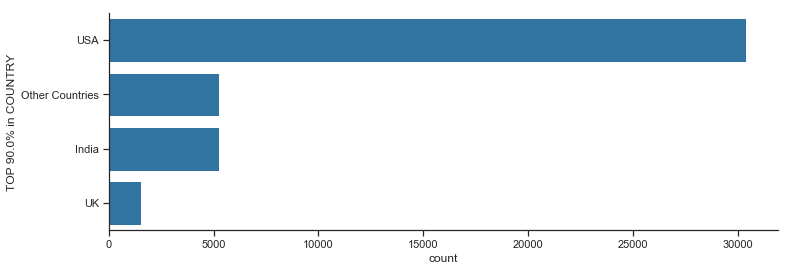

In [21]:
plot_top_cats('country', 0.90)

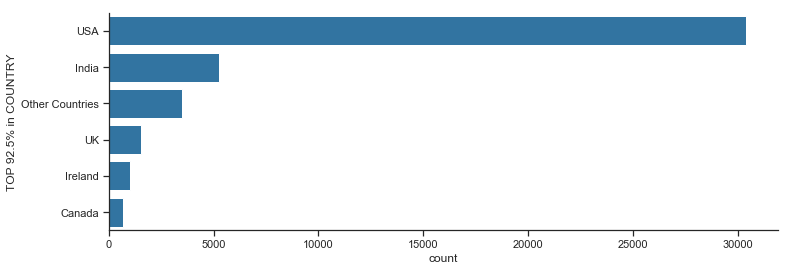

In [22]:
plot_top_cats('country', 0.925)

**Findings**
- As expected the super majority of reviews are posted in the US and, the India is the runner up.
- UK, Ireland, and Canada are following India.

**Notes**
- Companies day to day operations can be very different in each country. We are focusing on employees in the USA, India, UK, Ireland, and Canada.

In [23]:
countries_mask = (df.country == 'USA') | (df.country == 'UK') | (df.country == 'Ireland') | (df.country == 'Canada')
df = df[countries_mask]
del countries_mask
df.shape

(33697, 18)

___

**3rd Column** `dates` Date review posted

In [24]:
df['dates'] = pd.to_datetime(df['dates'], errors='coerce')  # Type Casting to date
df.sort_values(by='dates', ascending=False, inplace=True)  # Sort reviews by date
df.rename(columns={'dates': 'date_posted'}, inplace=True)

#### Distribution of Yearly Number of Reviews 

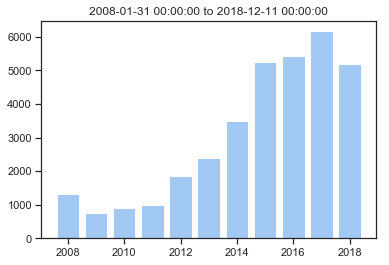

In [25]:
yearly = df.groupby(df['date_posted'].dt.year).size()
positions = yearly.index
plt.bar(positions, yearly.values)
plt.title(f'{df.date_posted.min()} to {df.date_posted.max()}');

In [26]:
df.set_index('date_posted').resample('1Y').count()

,company,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,link,city,state,country
date_posted,,,,,,,,,,,,,,,,,
2008-12-31,1310,1310,1303,1310,1310,1277,1310,1310,0,1310,1310,1310,1310,1310,1310,1310,1310
2009-12-31,740,740,734,740,740,722,740,740,0,740,740,740,740,740,740,740,740
2010-12-31,899,899,892,899,899,874,899,899,0,899,899,899,899,899,899,896,899
2011-12-31,999,999,995,999,999,765,999,999,0,999,999,999,999,999,999,998,999
2012-12-31,1859,1859,1856,1859,1859,1204,1859,1819,1305,1834,1827,1821,1859,1859,1859,1848,1859
2013-12-31,2379,2379,2377,2379,2379,1592,2379,2331,2325,2326,2329,2322,2379,2379,2379,2367,2379
2014-12-31,3481,3481,3475,3481,3481,2291,3481,3400,3388,3400,3400,3385,3481,3481,3481,3461,3481
2015-12-31,5259,5259,5247,5259,5258,3484,5259,4976,4964,4975,4984,4932,5259,5259,5259,5221,5259
2016-12-31,5427,5427,5420,5427,5427,3437,5427,5125,5082,5113,5115,5047,5427,5427,5427,5369,5427


**Findings**
- The majority of reviews posted are from 2015 to 2018.

___

**4th Column** `job-title` This string includes whether the reviewer is a 'Current' or 'Former' Employee at the time of the review. If Employee posting review Anonymously There is no value for job title and it presented with Anonymous Employee.

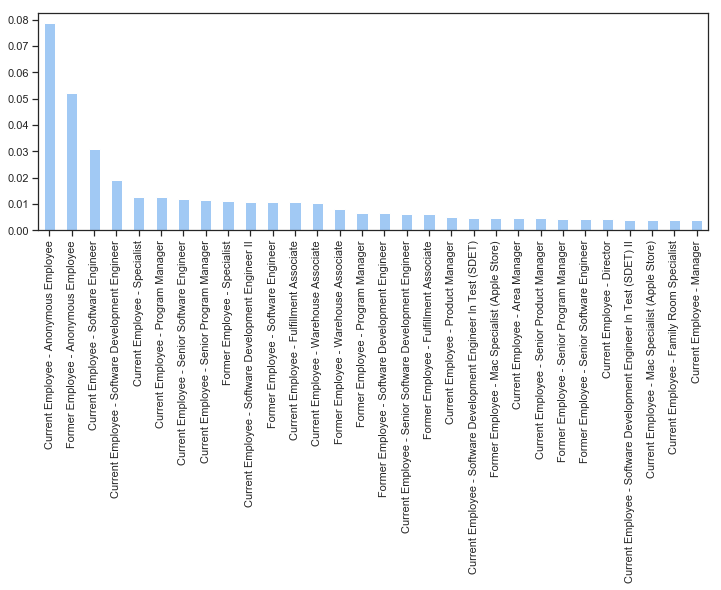

In [27]:
plt.figure(figsize=two_in_row)
(df['job_title'].value_counts().head(30) / len(df)).plot.bar();

**Findings** 
- **This column is not Tidy.** There are 3 values of  `Is reviewer is current or past employee` and `the Job Title` in this one column that each should be in its own column. If an employee is `anonymous`, Anonymous is listed instead of the job title.

##### Functions to extract if reviewer is `current_employee`,  `anonymou`, and the employee's `job_title`.

In [28]:
def clean_text(col):
    """Cleaning text from formatings."""
    col = col.str.strip()
    col = col.str.replace("(<br/>)", "")
    col = col.str.replace('(<a).*(>).*(</a>)', '')
    col = col.str.replace('(&amp)', '')
    col = col.str.replace('(&gt)', '')
    col = col.str.replace('(&lt)', '')
    col = col.str.replace('(\xa0)', ' ')  
    return col

df['job_title'] = clean_text(df['job_title'])

In [29]:
df['current_emp'] = df['job_title'].apply(lambda x: True if x.split()[0] == 'Current' else False)
df['anonymous'] = df['job_title'].apply(lambda x: True if 'Anonymous' in str(x) else False)

df['job_title'] = df['job_title'].apply(lambda x: x.split('-')[1])
df['job_title'] = df['job_title'].apply(lambda x: np.nan if 'Anonymous' in str(x) else x)

,job_title,current_emp,anonymous
3249,NaN,True,True
10043,Sortation Associate,False,False
44002,Specialist,True,False
60864,Software Development...,True,False
44555,Apple At Home Advisor,True,False


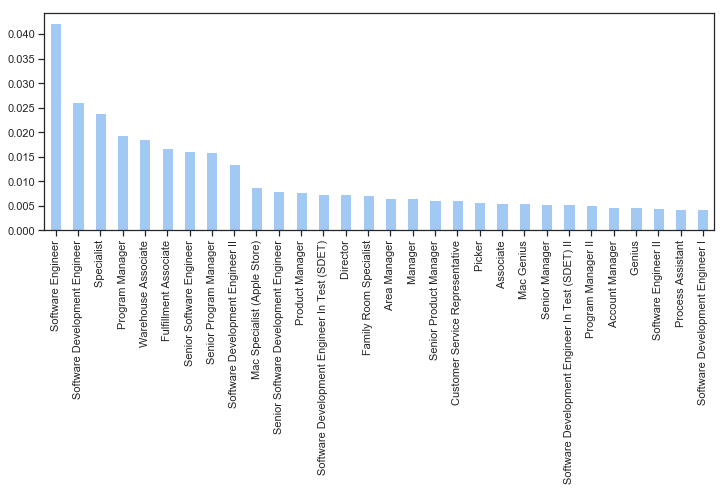

In [30]:
# Test
plt.figure(figsize=two_in_row)
(df['job_title'].value_counts().head(30) / len(df)).plot.bar();
df[['job_title', 'current_emp', 'anonymous']].sample(5)

In [31]:
# Most popular Job Titles in entire dataset i.e. all companies combined.
df['job_title'].value_counts()[:20]

 Software Engineer                               1423
 Software Development Engineer                    881
 Specialist                                       805
 Program Manager                                  653
 Warehouse Associate                              626
 Fulfillment Associate                            563
 Senior Software Engineer                         547
 Senior Program Manager                           538
 Software Development Engineer II                 456
 Mac Specialist (Apple Store)                     296
 Senior Software Development Engineer             266
 Product Manager                                  264
 Software Development Engineer In Test (SDET)     248
 Director                                         246
 Family Room Specialist                           244
 Area Manager                                     224
 Manager                                          221
 Senior Product Manager                           210
 Customer Service Representa

In [32]:
## Most popular group of employee wrote review in each company
df.groupby(['company', 'job_title']).size().sort_values(ascending=False)[:25]

company    job_title                                       
apple       Specialist                                         799
amazon      Warehouse Associate                                626
            Fulfillment Associate                              563
google      Software Engineer                                  508
microsoft   Program Manager                                    463
            Senior Program Manager                             461
            Software Development Engineer                      450
amazon      Software Development Engineer                      421
facebook    Software Engineer                                  356
apple       Mac Specialist (Apple Store)                       296
microsoft   Software Engineer                                  275
            Software Development Engineer II                   250
            Software Development Engineer In Test (SDET)       248
apple       Family Room Specialist                             244
mi

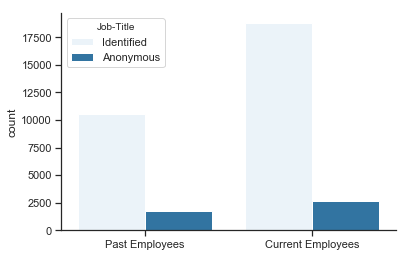

In [33]:
ax = sns.countplot(df['current_emp'], hue=df['anonymous'], color=bcolor)
ax.set_xticklabels(['Past Employees', 'Current Employees'])
ax.set_xlabel('')

ax.legend(['Identified', 'Anonymous'], 
          title="Job-Title")

sns.despine();

- Current Employees are more inclined to provide more information including their job title.
- For both past and current employees, NOT a significant number of reviews are anonymous.
____

**Columns 5th to 9th:** `summary`, `pros`, `cons`, and `advice_to_mgmt` are the actual text review content.


- Pros: Some of the best reasons to work at the Company.
- Cons: Some of the downsides of working at t the Company.
- Summary in the dataset seems to match Review Headline in glassdoor.

- Advice to Management is optional

In [34]:
# we leave summary (Review Headline) out of our analysis.
#text_cols = ['summary', 'pros', 'cons', 'advice_to_mgmt']
text_cols = [           'pros', 'cons', 'advice_to_mgmt']
for col in text_cols:
    df[col] = clean_text(df[col])

df[text_cols] = df[text_cols].replace('none', np.nan)
df[text_cols] = df[text_cols].replace('None', np.nan)
df['summary'][df['summary']=='.'] = np.nan # These are actually missing values

In [35]:
df.sample(5)[text_cols]

,pros,cons,advice_to_mgmt
6329,Fantastic team member...,Management was more c...,Do a good job where y...
6733,"Perks, compensation, ...","Job diversity, differ...",NaN
44862,Great company to work...,There are no cons bec...,no advice
56739,I enjoyed working in ...,The stack ranking sys...,NaN
38334,Company culture is gr...,low pay difficult to ...,NaN


___

**1-Star to 5-Starts Rating Columns** `overall_ratings`, `work_balance_stars`, `culture_values_stars`, `senior_mangemnet_stars`, `carrer_opportunities_stars`, and `comp_benefit_stars` We have 1 overall rating value and 5 specific values.

In [36]:
rating_cols = ['overall_ratings', 'work_balance_stars', 'culture_values_stars',
              'carrer_opportunities_stars', 'comp_benefit_stars', 'senior_mangemnet_stars']
df[rating_cols] = df[rating_cols].replace('none', np.nan)
df['overall_ratings'].nunique()

5

In [37]:
# Rating values to Numeric
for col in rating_cols:
    df[col] = pd.to_numeric(df[col], downcast='unsigned')
    
for col in rating_cols:
    if df[col].nunique() > 5:
        print(df[col].value_counts())

4.0    8025
5.0    7272
3.0    7264
2.0    4259
1.0    4091
3.5     588
4.5     569
2.5     356
1.5     124
Name: work_balance_stars, dtype: int64
5.0    9381
4.0    8488
3.0    6997
2.0    3640
1.0    2791
3.5     548
4.5     301
2.5     288
1.5     101
Name: carrer_opportunities_stars, dtype: int64
5.0    11383
4.0    10407
3.0     5914
2.0     1866
1.0     1064
4.5      869
3.5      735
2.5      270
1.5       40
Name: comp_benefit_stars, dtype: int64
4.0    8056
3.0    7088
5.0    7003
1.0    4700
2.0    4530
3.5     311
2.5     242
4.5     219
1.5     138
Name: senior_mangemnet_stars, dtype: int64


The rating is based on a widespread scale from 1 the worst to 5 the best. Some rating values in rating columns are in between levels, i.e. 1.5, 2.5, 3.5, or 4.5. We correct these rating by lowering them one level. E.g., 1.5 to 1, 2.5 to 2. Note There are no 0.5 nor 5.5 ratings to be corrected.

Our approach is conservative here, and all mid-stars ratings are truncating to lower star rating. The other approach could be using a binomial distribution with a 50% success rate, to divide the ratings between higher and lower stars levels.

In [38]:
def five_ratings_only(col):
    for idx in col.value_counts().index:
        col[col==idx] = int(float(idx))
    return col

for col in rating_cols:
    df[col] = five_ratings_only(df[col])
    df[col].astype(np.unsignedinteger, errors='ignore')

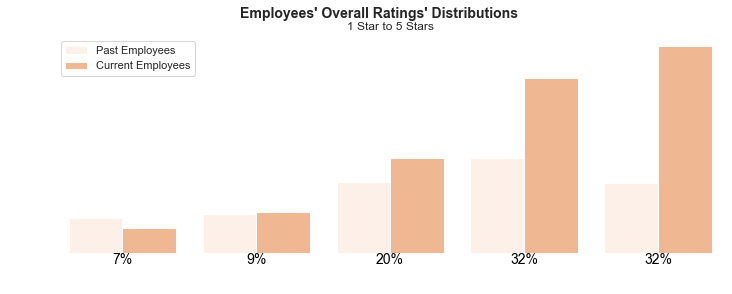

In [39]:
fig, ax = plt.subplots(figsize=two_in_row)

fig.suptitle('Employees\' Overall Ratings\' Distributions', fontsize=14, fontweight='bold')

color = sns.color_palette()[1]

sns.countplot(data=df, x='overall_ratings', hue='current_emp', color=color)

ax.set(title='1 Star to 5 Stars')
ax.legend(['Past Employees', 'Current Employees'])
ax.set_axis_off()

locs = ax.get_xticks()
labels = ax.get_xlabel()

counts = list(df['overall_ratings'].value_counts(normalize=True).iloc[::-1])
for loc, lable, count in zip(locs, labels, counts):

    text = '{:0.0f}%'.format(100*count)
    ax.text(loc, 0, text, color='black', va='top', ha='center', fontsize=14)

**Findings:**
 - This plot shows unhappy past employees were more inclined to leave a low review than current employees.
 - We can see the current/past ratio increases as rating stars increeases. 
 - Happier current employees are leaving higher rating reviews maybe to show their appreciation.
 - Uphappier past employees are leaving lower rating reviews maybe to be finally heard!

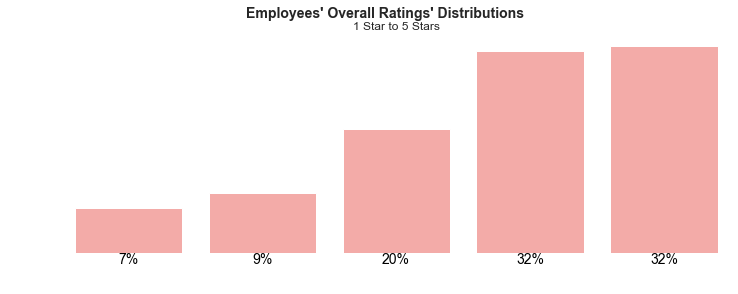

In [40]:
fig, ax = plt.subplots(figsize=two_in_row)

fig.suptitle('Employees\' Overall Ratings\' Distributions', fontsize=14, fontweight='bold')

color = sns.color_palette()[3]

sns.countplot(data=df, x='overall_ratings', hue=None, color=color)

ax.set(title='1 Star to 5 Stars')
ax.set_axis_off()

locs = ax.get_xticks()
labels = ax.get_xlabel()

counts = list(df['overall_ratings'].value_counts(normalize=True).iloc[::-1])
for loc, lable, count in zip(locs, labels, counts):

    text = '{:0.0f}%'.format(100*count)
    ax.text(loc, 0, text, color='black', va='top', ha='center', fontsize=14)

**Findings**
- This plot is a repeat of the previous plot without distinguishing between past and current employees.
- Overall star rating shows that almost two-thirds of all employees are generally happy about companies in our data set. One-Fifth neutral and about 15% troubled. 
___

**Helpful Count Column** A count of how many people found the review to be helpful. This variable is the only numeric feature that comes with our dataset. Let's dig into it.

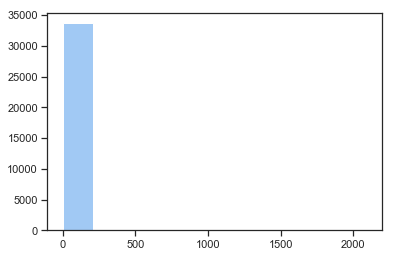

In [41]:
plt.hist(df['helpful_count']);

Our first histogram shows evidence of `extreme outliers`.

In [42]:
def hist_magnifier(df, x, xlim1, xlim2, binsize):
    plt.hist(data=df, x=x, bins=np.arange(xlim1, xlim2+binsize, binsize))
    plt.xlim(xlim1, xlim2);

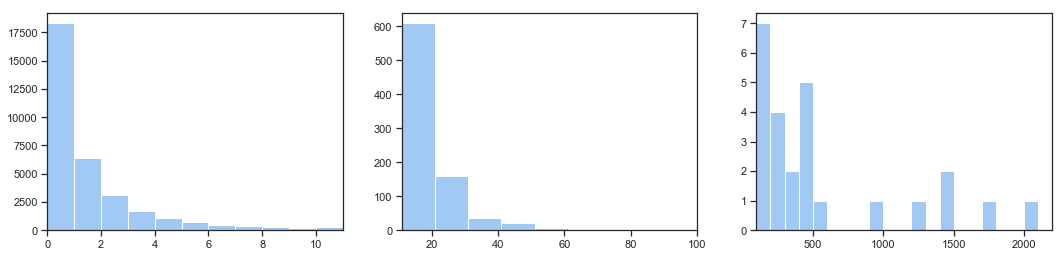

In [43]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
hist_magnifier(df, df['helpful_count'], 0, 11, 1)

plt.subplot(1, 3, 2)
hist_magnifier(df, df['helpful_count'], 11, 100, 10)

plt.subplot(1, 3, 3)
hist_magnifier(df, df['helpful_count'], 100, df['helpful_count'].max()+100, 100)

In [44]:
cum_hist = df['helpful_count'].value_counts(normalize=True).cumsum()
cum_hist[cum_hist<0.95]

0    0.54
1    0.73
2    0.83
3    0.88
4    0.91
5    0.93
6    0.95
Name: helpful_count, dtype: float64

**Findings:**

- After some trial and error, we arrived with these 3 histograms. Please pay attention to count for each plot and x data range.
- More than half of the reviews have no helpful_count, i.e. no one found those reviews helpful or worthy. 
- Only 5% of reviews are found helpful by at least 5 other people
- Any helpful_count of 50 or more to the highest count of about low two thousand are far in between.

**Note:**
- We will work on this column again later when doing feature engineering.
___

**Link Column:** Direct link to the page that contains the review. This column is not required for analysis.

In [45]:
del df['link']

___

### Missing Values
 - Cleaning Missing Values
 - Plotting Missing Values' Counts

In [46]:
def plot_missings(df, figsize=(12, 4)):
    """Plot missing values bar visualization for each column of a DataFrame."""
    
    print(f'The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.')
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style='ticks', palette='pastel')
    color = sns.color_palette()[3]
    
    x = df.isna().sum().index.values
    y = df.isna().sum()
    sns.barplot(x, y, color=color, ax=ax)
    locs, labels = plt.xticks(rotation=90)
    for loc, label, missings, in zip(locs, labels, y):
        if not missings:
            ax.text(loc, 0, 'None', rotation=0, va='bottom', ha='center')
        else:
            ax.text(loc, missings, missings, rotation=0, va='bottom', ha='center')

    ax.set(title='Missing Value Counts in all Columns', xlabel='Columns', ylabel='Counts')
    sns.despine() # remove the top and right borders

The DataFrame has 33697 rows and 19 columns.


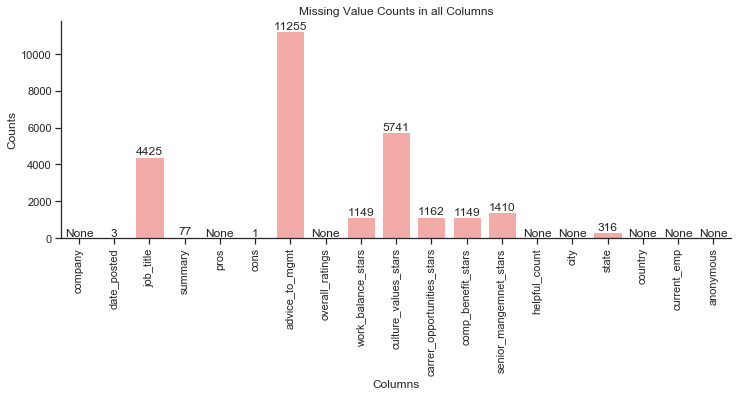

In [47]:
plot_missings(df)

- Fortunately, there are no missing values in for overall stars rating while there are many missings for other ratings the most for Culture and Values.
- We certainly want to be aware of what's missing, but in our analysis, it doesn't seem we have to drop any of these missings.

In [48]:
# Test; Checking the review with missing cons comment.
df[df['cons'].isna()]

,company,date_posted,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,city,state,country,current_emp,anonymous
42756,apple,2015-07-27,NaN,a great place,everything is awesome!!,NaN,NaN,4,5.0,5.0,5.0,5.0,5.0,0,Charlotte,NC,USA,True,True


In [49]:
# Test; Checking 4 reviews with missing date_posted.
df[df['date_posted'].isna()]

,company,date_posted,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,city,state,country,current_emp,anonymous
7820,amazon,NaT,Software Development...,An Amazing Place to Work,I've been at Amazon f...,"No cons, so far - ser...",NaN,5,4.0,5.0,5.0,5.0,5.0,580,Phoenix,AZ,USA,True,False
36105,netflix,NaT,Customer Service Rep...,Decent,They give a lot of of...,"No room for growth, p...",NaN,4,1.0,1.0,2.0,3.0,1.0,8,Aurora,CO,USA,False,False
40863,apple,NaT,Family Room Specialist,It all depends on loc...,- Exciting work envir...,- Depending on manage...,NaN,4,3.0,4.0,4.0,5.0,3.0,1,Orlando,FL,USA,False,False


**Findings:**
- The first review with missing date has an extremely very high helpful count, i.e. 580. Reading the `pros` reveal this employee has only worked at Amazon for 1 month.
- - How could someone working only 1 month write such strong positive review?
- - The Same review job title shows a `management position`.
- - There is no advice to management for this review either.
- Based on the above I am very doubtful this is an honest review. There is reasonable chance employees of this manager or department were asked to mark the review helpful.


- Having the length of employment as a variable (column) in this dataset could be used to filter similar reviews and also weigh more on reviews for those employees who stayed a minimum reasonable time with their companies.


- Highest missing values are for those who didn't leave feedback/advice for their higher managers. This is a very valuable part of this dataset as companies can aggregate, summarize and learn a lot from this information.

In [50]:
# Drop rows/reviews with no 'advice_to_managment`
df = df[df['advice_to_mgmt'].notna()]

##### Looking at our cleaned dataset

In [51]:
df.sample()

,company,date_posted,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,city,state,country,current_emp,anonymous
16481,amazon,2017-03-15,Manager,Amazon Corporate with...,Passionate and intell...,"Poor management, poor...",More cross-functional...,3,5.0,3.0,5.0,4.0,2.0,0,Foster City,CA,USA,True,False


In [52]:
df.describe().transpose()  # Numeric Columns

,count,mean,std,min,25%,50%,75%,max
overall_ratings,22442.0,3.54,1.25,1.0,3.0,4.0,5.0,5.0
work_balance_stars,21945.0,3.17,1.33,1.0,2.0,3.0,4.0,5.0
culture_values_stars,17872.0,3.49,1.41,1.0,2.0,4.0,5.0,5.0
carrer_opportunities_stars,21955.0,3.38,1.30,1.0,2.0,4.0,4.0,5.0
comp_benefit_stars,21951.0,3.82,1.09,1.0,3.0,4.0,5.0,5.0
senior_mangemnet_stars,21841.0,3.05,1.37,1.0,2.0,3.0,4.0,5.0
helpful_count,22442.0,2.49,26.65,0.0,0.0,1.0,2.0,2094.0


In [53]:
df.info(null_counts=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22442 entries, 8120 to 46760
Data columns (total 19 columns):
company                       category
date_posted                   datetime64[ns]
job_title                     object
summary                       object
pros                          object
cons                          object
advice_to_mgmt                object
overall_ratings               uint8
work_balance_stars            float64
culture_values_stars          float64
carrer_opportunities_stars    float64
comp_benefit_stars            float64
senior_mangemnet_stars        float64
helpful_count                 int64
city                          object
state                         object
country                       object
current_emp                   bool
anonymous                     bool
dtypes: bool(2), category(1), datetime64[ns](1), float64(5), int64(1), object(8), uint8(1)
memory usage: 2.8+ MB


**Notes:**
- We had to do extensive data cleaning on job_title column, if we wanted to find answers to questions similar to "what positions in general and for each company ratings have need highest attention for workplace improvements?".

- We still have to figure out what to do with healful_count outliers.

##### end of Variables Assessment, Data Cleaning, and Univariant Exploration.
___

## What insights and questions are we exploring?<a name="Context"></a>

This dataset is a fraction of what can be easily found on glassdoor.com which already provides so much information about each company. We are not going to focus on answering trivial questions similar to what company has the highest ratings. We like to find the pattern between what matters to employees regardless in general.
___

## Bivariate and Multivariate Explorations <a name="Multivariate"></a>

We want to see the relationships between 6 star ratings variables. We need to understand if these variables interact with one another.

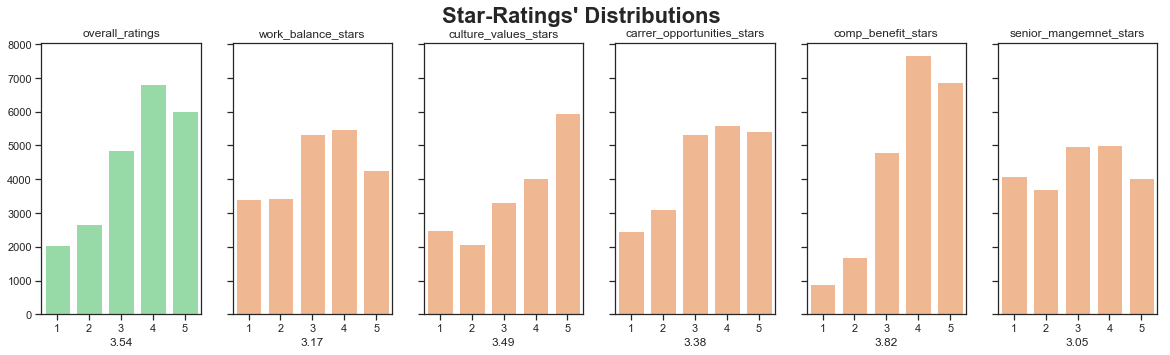

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(20, 5))
fig.suptitle('Star-Ratings\' Distributions', fontsize=22, fontweight='bold')
xticks=[1, 2, 3, 4, 5]
for ax, col in zip(axes, rating_cols):
    
    if col=='overall_ratings':
        color = sns.color_palette()[2]
    else:
        color = sns.color_palette()[1]
        
    ax = sns.countplot(ax=ax, data=df, x=df[col], color=color, order=xticks, hue=None)
    # plt.ylim(0, 12000)
    mean = '{:0.2f}'.format(df[col].mean())
    ax.set(title=ax.get_xlabel(), xlabel=mean, ylabel='')

    # TODO: Print percentage of each bar on each bar on it.

**Findings Here:**

A lot to be discussed here.

- Means of  the Overall-Rating and Culture-and-Values are closest together but the pattern or shape of distributions of  the Overall-Rating best matches with Compensations-and-Benefits.
- As said above the Overall-Rating distribution pattern best follows Compensation-and-Benefits. 
- Per these plots employees mostly are happy about their pay, or maybe this means tech employees only work where they feel happy about their pay.
- The highest negativity is about Sr. management. Lowest mean and (relatively) the highest number of 1-star ratings.
- Work-Life Balance pattern looks very similar to Sr. Management both in shape and means.

### 2 Overall Rating vs Other Ratings Trend and Averages

For each five level of the Overa Rating we have 5 other sub-ratings. That is 25 data points. We want to plot the mean of each sub-rating at every oerall rating star.

In [55]:
def ratings_trend(df=df, rating_cols=rating_cols, hue=None):
    plt.figure(figsize=(10, 10))

    colors = ['grey', 'blue', 'green', 'red', 'brown']
    ypos = 4.25
    for col, color in zip(rating_cols[1:], colors):
        sns.pointplot(data=df, x='overall_ratings', y=col, color=color, hue=hue)
        plt.text(0.5, ypos, str(col), color=color)
        ypos += 0.15

    plt.ylim(1, 5)
    plt.grid()
    plt.xlabel('Overall Rating Stars')
    plt.ylabel('Star-Level average ratings of each Sub-Ratings vs. Overall Rating');

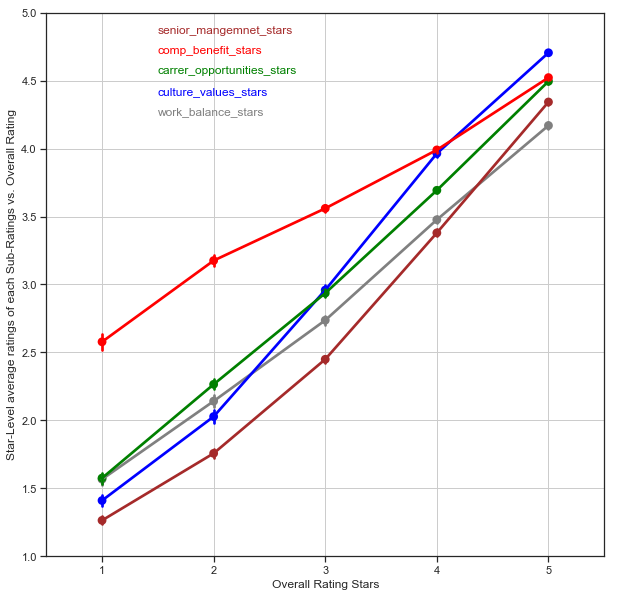

In [56]:
ratings_trend(df)

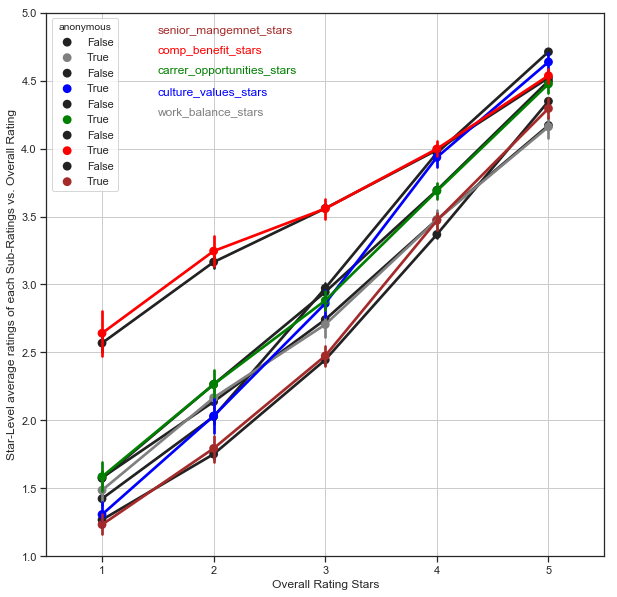

In [57]:
# Looking if each trend is different between anonymous and none-anonymous reviewers
ratings_trend(df, hue='anonymous')

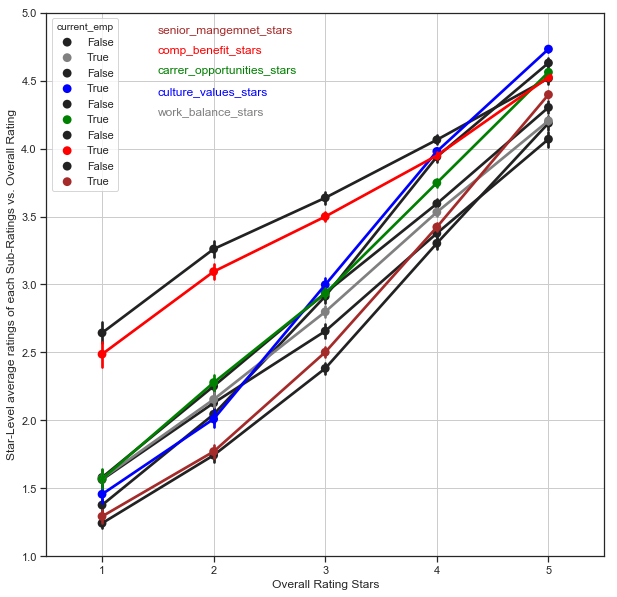

In [58]:
# Looking if each trend is different between current and past employee reviewers
ratings_trend(df, hue='current_emp')

**Findings:**

This plot is gold for our analysis.

- Employees who were given the highest Overall -Rating, i.e. 5 Stars, on average, are given the highest ratings to the Culture-and-Values.
- Employees who were giving the highest overall rating, i.e. 5 Stars, on average, still are least happy with the Work-Life balance.
- For unhappy 1 or 2 stars overall rating, Sr Management seems to be the most critical issue impacting it. The runner up affecting unhappy employees in the plot is the Culture-and-Values.
- It's interesting to see the unhappier (lowest overall rating) employees are the least concern about Compensations-and-Benefits. As we can see the Compensation-Benefits has the highest mean from 1-Star to 4 Stars.

end of bivariate explorations
___

## Feature Engineering<a name="Feature"></a>

Basedon what we have learned sofar we make and explore some new variables, i.e. columns.

1. Detail Factor based on review length i.e. word count
- Time Factor based on date_posted
- Helpful Factor based on number of people found a review helpful i.e. agreeing with it.
- Overall-Rating Factor, i.e. Mapping Values to the Overall-Rating Stars

- Anonymous reviews are less credible.

- Review Score = Detail-Factor * Time-Factor * Helpfulness * Overall_Rating * Anonymous-Factor

### Detail Factor based on review length i.e. word count

In real life we pay attention when someone cares and pays attention to a subject giving detailed and possibly passionate feed back on subject than short quick answers. We want ot take this fact in consideration in this data set. someone leaving a detailed review summary, pros and cons points and advise for management with about 1000 words deserve more weight than a partial quick review with 15 words. To measure this we make a new feature `detail_factor` based on the overall length of the different part s of the review. 

There 4 text columns for each review divided into `Summary`, `Pros`, `Cons`, and `Advice to Management`. 

In [59]:
review_cols = ['pros', 'cons', 'advice_to_mgmt']
correction_dict = {r'-': '',
                   r'w/': 'with',
                   r' i ': ' I ',
                   r' & ': ' and '}

df[review_cols] = df[review_cols].replace(regex=correction_dict)

In [60]:
# Counting Words
df['wordcount'] = 0
for col in review_cols:
    df['wordcount'] += df[col].astype(str).apply(lambda text: len(text.split()))

In [61]:
df['wordcount'].describe()

count    22442.00
mean       104.86
std        119.34
min          7.00
25%         39.00
50%         72.00
75%        123.00
max       3655.00
Name: wordcount, dtype: float64

In [62]:
df = df[df['wordcount'] >= 39]

In [63]:
def distplot_closelook(series, **kwarg):
    """"""
    
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 2))
    sns.boxplot(series, color=bcolor)
    
    ax0.set_xlabel(f'All {len(series)} observations')
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 2))
    sns.boxplot(series, ax=ax0, **kwarg)
    ax0.set_xlim(0, np.percentile(series, 25))
    ax0.set_xlabel(f'Bottom (left) 25% Distribution')

    sns.boxplot(series, ax=ax1, **kwarg)
    ax1.set_xlim(np.percentile(series, 75), series.max())
    ax1.set_xlabel(f'Top (right) 25% Distribution')    

count    16987.00
mean       130.44
std        126.91
min         39.00
25%         63.00
50%         92.00
75%        146.00
max       3655.00
Name: wordcount, dtype: float64

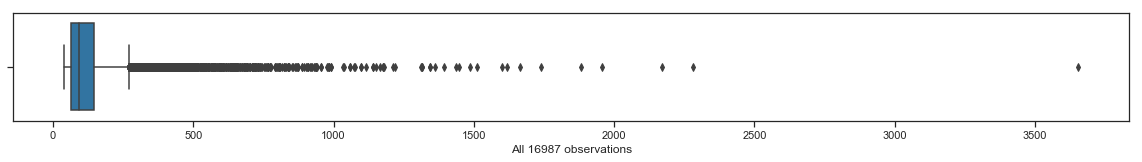

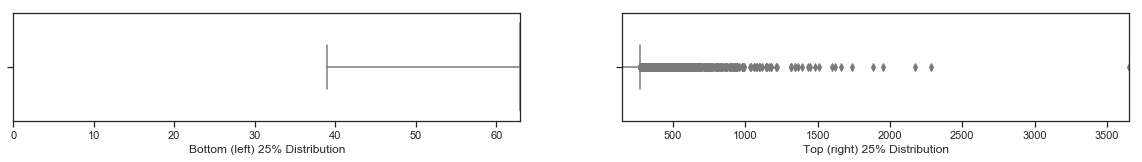

In [64]:
distplot_closelook(df['wordcount'])
df['wordcount'].describe()

I think boxen plot works great showing spread of exterem outliers in large distributions. The boxen plot here shows:
- An review with more than 3500 words in its comments and a couple of reviews arounf 2250.
- There are exterem outliers with more than 1000 words.

In [65]:
# Assigns values outside 92.50% boundary to boundary value. 
# In other words capping word_count to a set ceiling value.
df['wordcount'] = df['wordcount'].clip(0, np.percentile(df['wordcount'], 90.0))

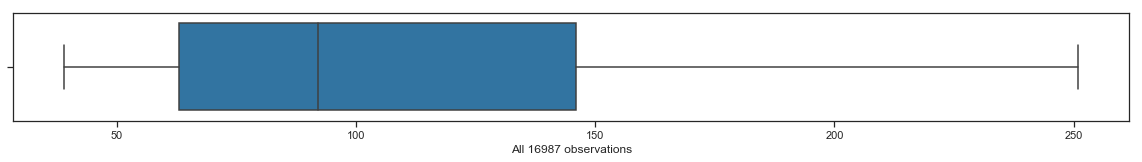

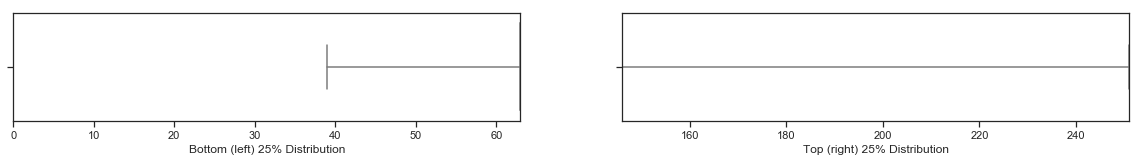

In [66]:
distplot_closelook(df['wordcount'])

- With trial and error, we find out that at 90.0% upper threshold, all word_count outliers included in our data without being an outlier. We didn't have to lose these reviews because of thier word_count outliers; Instead we capped them at a highest number.
- We now can bin (group) word_count values give each a weight for furthur analysis.

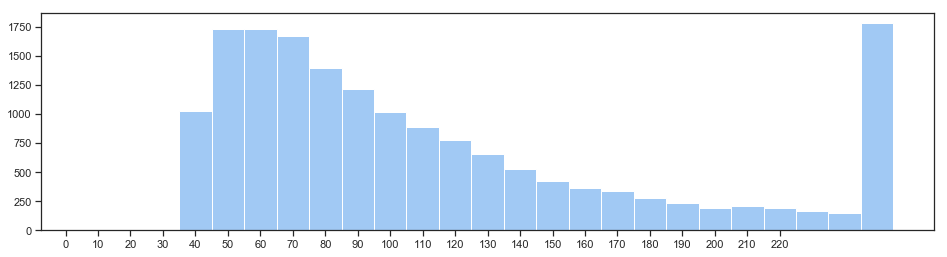

In [67]:
plt.figure(figsize=(16, 4))
bin_size = 10
bins = np.arange(5, np.max(df['wordcount'])+bin_size, bin_size)
plt.hist(df.wordcount, bins)
plt.xticks(np.arange(0, 220+10, 10));

- Now looking at trimmed word_count distribution, we can see with proper trimming and binning, the word_cound values can be groupped (binned for number of word counts and given a weight for each review.
- The last bar includes/caps all work_count outliers together.

In [68]:
bins

array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
       135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255])

In [69]:
# assign/map each review to the bin it belongs
bin_id = pd.cut(df['wordcount'], bins=bins, right=False, include_lowest=True)

# We linearly assign a score for each bin
bv = 1 / bins.shape[0]
f'Number of bins: {bins.shape[0]} - Each bins\' value: {bv} (evenly distributed over all bins)'

"Number of bins: 26 - Each bins' value: 0.038461538461538464 (evenly distributed over all bins)"

In [70]:
bins_table =  bin_id.value_counts().sort_index().to_frame().reset_index()
# calculate each bin wc_score increamentally from 0 to 1
bins_table['bin_score'] = (bins_table.index + 2) * bv  
bins_table

,index,wordcount,bin_score
0,"[5, 15)",0,0.08
1,"[15, 25)",0,0.12
2,"[25, 35)",0,0.15
3,"[35, 45)",1025,0.19
4,"[45, 55)",1735,0.23
5,"[55, 65)",1736,0.27
6,"[65, 75)",1674,0.31
7,"[75, 85)",1400,0.35
8,"[85, 95)",1219,0.38
9,"[95, 105)",1021,0.42


In [71]:
mapping_series = pd.Series(data=bins_table['bin_score'].values, index=bins_table['index'])  # make a series with bins' names (edges) as index and bin_score as value
mapping_series

index
[5, 15)       0.08
[15, 25)      0.12
[25, 35)      0.15
[35, 45)      0.19
[45, 55)      0.23
[55, 65)      0.27
[65, 75)      0.31
[75, 85)      0.35
[85, 95)      0.38
[95, 105)     0.42
[105, 115)    0.46
[115, 125)    0.50
[125, 135)    0.54
[135, 145)    0.58
[145, 155)    0.62
[155, 165)    0.65
[165, 175)    0.69
[175, 185)    0.73
[185, 195)    0.77
[195, 205)    0.81
[205, 215)    0.85
[215, 225)    0.88
[225, 235)    0.92
[235, 245)    0.96
[245, 255)    1.00
dtype: float64

In [72]:
# for each review, map the weight/score of the bin it beloges to
df['detail_factor'] = bin_id.map(mapping_series)

In [73]:
# Test
df[['wordcount', 'detail_factor']].sample(7)

,wordcount,detail_factor
52052,73,0.31
51321,90,0.38
58362,143,0.58
45676,46,0.23
60365,228,0.92
74,112,0.46
53989,170,0.69


- As seen above the detail_factor value is from (0 to 1).

end of engineering detail_factor
___

### Time Factor based on date_posted


We are interested in the direction and how a workplace is evolving than just averaging historic data `evenly` over time. 

A recent review must have much higher weight than a review of 5 years ago. To take this into consideration we define a new feature `time_factor` that is from (0 to 1). 1 for a review left today and zero for 5 years (1826 days) or beyond.

This is a linear weight system we choose to use; Perhaps it is not  the most optimal but it should be practical enough for our dataset for initial experiemnts. 

In [74]:
max_days = 5 * 364.25 
df['review_days'] = pd.to_numeric((pd.datetime.today() - df['date_posted']).dt.days)
df['time_factor'] = df['review_days'].apply(lambda x: 1 - x/max_days if x < max_days else 0.0)

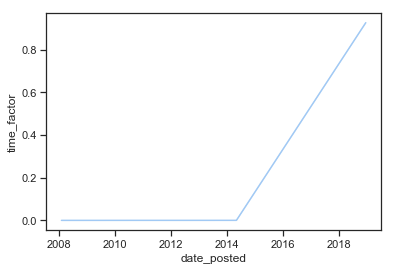

In [75]:
# Test
sns.lineplot(data=df, x=df['date_posted'], y=df['time_factor'])  # reviews time_factor values for the last 5 year

This plot confirms linear weightig of our reviews over the last 5 years.
____

### Helpful Factor based on number of people found a review helpful i.e. agreeing with it

To take helpful_count into account for every 10 people finding a review helpful it doubles the values of that review (This calculation is now rounding to whole numbers. i.e. ints)

In [76]:
df['helpful_count'] = df['helpful_count'].clip(0, 100)
df['helful_factor'] = df['helpful_count'].apply(lambda x: 1 + x / 10)

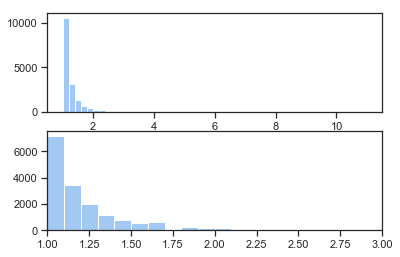

In [77]:
plt.figure()

plt.subplot(2, 1, 1)
plt.hist(df['helful_factor'], bins=50)


plt.subplot(2, 1, 2)
plt.hist(df['helful_factor'], bins=100)
plt.xlim(1, 3);

As seen earlier in this notebook the feature has lots of exterem outliers, but this outliers (as long as they are not errors) don't distort our analysis and shall not be discarded.

In [78]:
# Test
df[['helpful_count', 'helful_factor']].sample(7)

,helpful_count,helful_factor
24755,10,2.0
1180,0,1.0
59822,0,1.0
8210,0,1.0
14582,1,1.1
43455,1,1.1
59919,0,1.0


___

### Assigning Numeric Score Value to Overall-Rating Stars

We use a scoring mapping as follows:
- 5 Stars: 1.00
- 4 Stars: 0.75
- 3 Stars: 0.50
- 2 Stars: 0.25
- 1 Star:  0.00

In [79]:
df['stars_score'] = df['overall_ratings'].apply(lambda x: (int(x) - 1) / 4)

In [80]:
# Test
df[['stars_score','overall_ratings']].sample(7)

,stars_score,overall_ratings
61557,0.75,4
12296,0.00,1
34933,0.75,4
15306,0.00,1
59387,0.50,3
41785,0.50,3
19423,0.00,1


Overall-Rating Values also, are from 0 to 1 but not continuous.
___

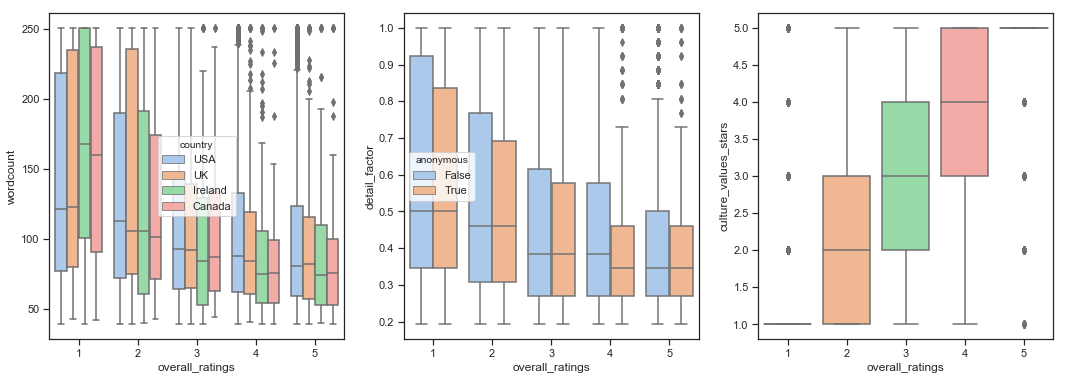

In [81]:
plt.figure(figsize=(18,6))

plt.subplot(1, 3, 1)
sns.boxplot(data=df, x=df['overall_ratings'], y=df['wordcount'], hue='country')

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x=df['overall_ratings'], y=df['detail_factor'], hue='anonymous')

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x=df.overall_ratings, y=df.culture_values_stars)

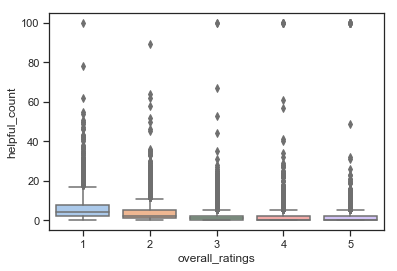

In [82]:
sns.boxplot(data=df, x=df.overall_ratings, y=df.helpful_count)

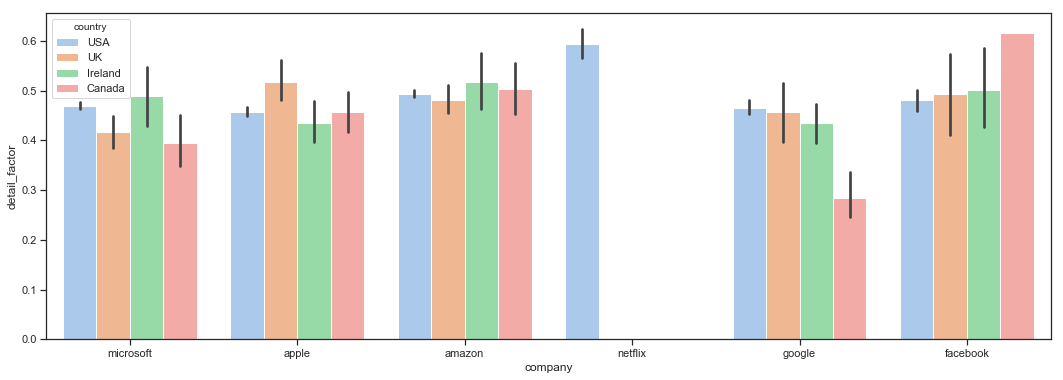

In [83]:
plt.figure(figsize=(18,6))
sns.barplot(data=df, x='company', y='detail_factor', hue='country');

In [84]:
df.groupby(['company', 'country']).count()

date_posted  job_title  summary    pros    cons  advice_to_mgmt  overall_ratings  work_balance_stars  culture_values_stars  carrer_opportunities_stars  comp_benefit_stars  senior_mangemnet_stars  helpful_count    city   state  current_emp  anonymous  wordcount  detail_factor  review_days  time_factor  helful_factor  stars_score
company   country                                                                                                                                                                                                                                                                                                                                           
microsoft Canada          72.0       60.0     72.0    72.0    72.0            72.0             72.0                72.0                  72.0                      72.0                  71.0                    72.0           72.0    72.0    72.0         72.0       72.0       72.0           72.0         72.0         72.0           72.0         72.0
          Ireland         77.0       67.0     77.0    77.0    77.0            77.0             77.0                77.0                  70.0                      77.0                  77.0                    77.0           77.0    77.0    72.0         77.0       77.0       77.0           77.0         77.0         77.0           77.0         77.0
          UK             142.0      114.0    142.0   142.0   142.0           142.0            142.0               141.0                 139.0                     142.0                 142.0                   141.0          142.0   142.0   142.0        142.0      142.0      142.0          142.0        142.0        142.0          142.0        142.0
          USA           4729.0     4140.0   4722.0  4729.0  4729.0          4729.0           4729.0              4671.0                3111.0                    4671.0                4672.0                  4662.0         4729.0  4729.0  4729.0       4729.0     4729.0     4729.0         4729.0       4729.0       4729.0         4729.0       4729.0
apple     Canada         120.0      112.0    120.0   120.0   120.0           120.0            120.0               119.0                 111.0                     119.0                 118.0                   118.0          120.0   120.0   120.0        120.0      120.0      120.0          120.0        120.0        120.0          120.0        120.0
          Ireland        129.0      111.0    128.0   129.0   129.0           129.0            129.0               129.0                 122.0                     129.0                 129.0                   129.0          129.0   129.0     8.0        129.0      129.0      129.0          129.0        129.0        129.0          129.0        129.0
          UK             163.0      145.0    163.0   163.0   163.0           163.0            163.0               162.0                 150.0                     162.0                 162.0                   162.0          163.0   163.0   163.0        163.0      163.0      163.0          163.0        163.0        163.0          163.0        163.0
          USA           3179.0     2870.0   3169.0  3179.0  3179.0          3179.0           3179.0              3139.0                2475.0                    3141.0                3135.0                  3129.0         3179.0  3179.0  3179.0       3179.0     3179.0     3179.0         3179.0       3179.0       3179.0         3179.0       3179.0
amazon    Canada         107.0       99.0    107.0   107.0   107.0           107.0            107.0               101.0                 101.0                     101.0                 101.0                   101.0          107.0   107.0   107.0        107.0      107.0      107.0          107.0        107.0        107.0          107.0        107.0
          Ireland        100.0       86.0    100.0   100.0   100.0           100.0            100.0                99.0                  96.0                      99.0             

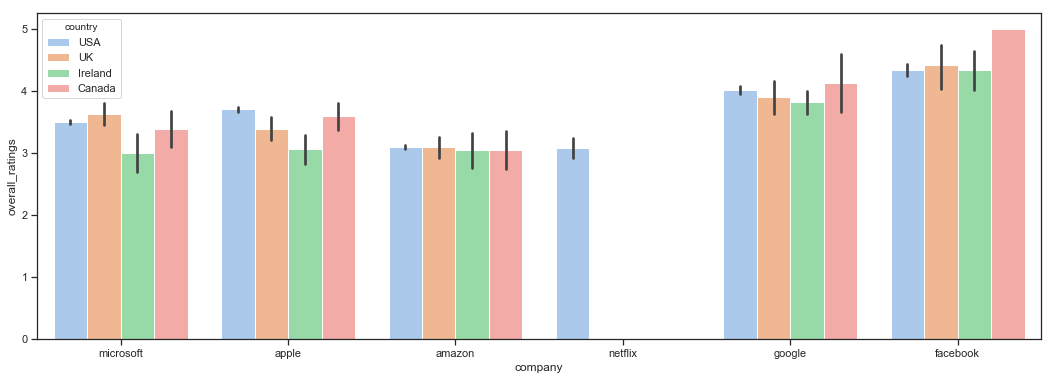

In [85]:
plt.figure(figsize=(18,6))
sns.barplot(data=df, x='company', y='overall_ratings', hue=df.country);

- This results and lots of other variations of it based on new features that we made doesn't seem to be compelling.
- We will use all actual ratings values in the data set.

In [86]:
df.groupby('company').mean()[['detail_factor', 'overall_ratings']].sort_values('detail_factor', ascending=False)

,detail_factor,overall_ratings
company,,
netflix,0.59,3.07
amazon,0.49,3.09
facebook,0.48,4.34
microsoft,0.47,3.50
google,0.46,3.99
apple,0.46,3.66


(-0.5, 10.5)

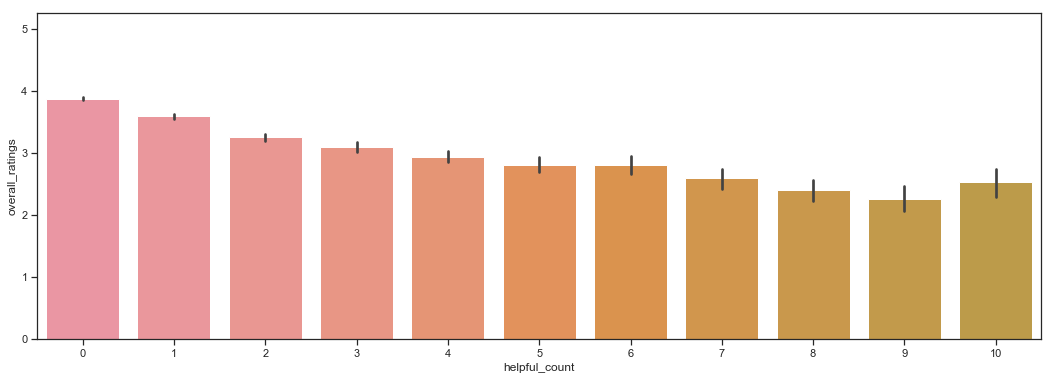

In [87]:
plt.figure(figsize=(18,6))
sns.barplot(data=df, x=df.helpful_count, y=df.overall_ratings);
plt.xlim(-0.5, 10+0.5)

In [88]:
cum_hist = df['helpful_count'].value_counts(normalize=True).cumsum()
cum_hist[cum_hist < 0.975].index.max()

14

Considering that 97.5% of reviews have a helpful_count of 10 or less, We can see that lower rating reviews get more helpful counts.

In [89]:
df.groupby('country').mean().sort_values(by='overall_ratings', ascending=False)

,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,current_emp,anonymous,wordcount,detail_factor,review_days,time_factor,helful_factor,stars_score
country,,,,,,,,,,,,,,,
USA,3.45,3.12,3.40,3.33,3.79,2.98,2.39,0.61,0.12,114.24,0.48,1662.39,0.30,1.24,0.61
UK,3.41,3.06,3.47,3.22,3.59,2.96,2.58,0.55,0.14,113.15,0.48,1122.29,0.44,1.26,0.60
Canada,3.39,2.91,3.42,3.03,3.74,2.87,2.30,0.61,0.09,106.90,0.45,1113.26,0.43,1.23,0.60
Ireland,3.38,3.14,3.53,3.16,3.71,2.94,3.85,0.59,0.15,111.47,0.47,1184.51,0.42,1.38,0.59


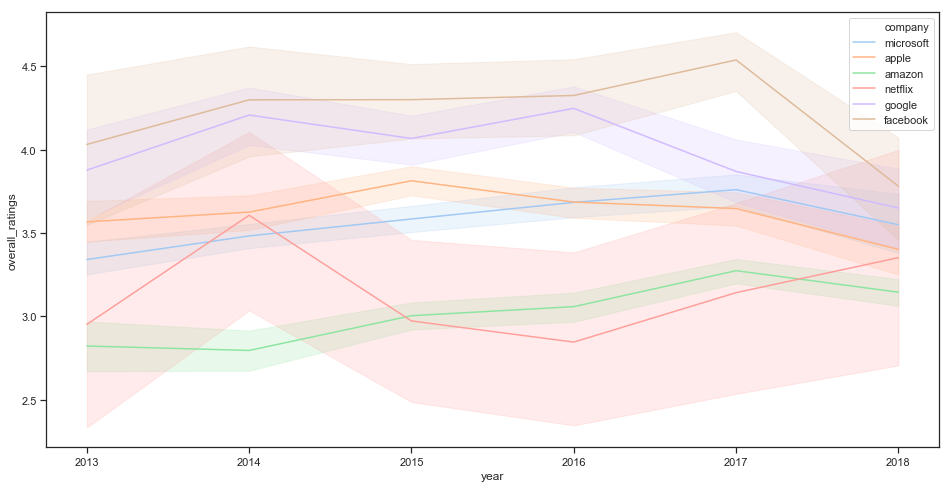

In [90]:
# Yearly Overall-Rating trending/changes for each company
df['year'] = df['date_posted'].dt.year

plt.figure(figsize=(16, 8))
sns.lineplot(data=df[df.year >= 2013], 
             x='year', y='overall_ratings', 
             hue='company')

del df['year']

Except Netflix that is a much smaller comany in the dataset and much fewer reviews. The Overall-Rating of companies been decling in 2018 converging together.

In [91]:
# Saving cleaned and filtered dataset for explanatory
df.to_csv(os.path.join(dataset_path, 'employee_reviews_clean.csv'), index=None)